<a href="https://colab.research.google.com/github/doronin99/RecoServiceTemplate/blob/task6/notebooks/learn2rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies installing

In [ ]:
pip install -q dill

In [ ]:
pip install -q shap

In [ ]:
pip install -q lightfm

In [ ]:
pip install -q rectools

In [ ]:
import warnings
warnings.simplefilter('ignore')

import dill
import gc
import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.dataset import Dataset
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models import LightFMWrapperModel, PopularModel
from rectools import Columns
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Callable, Dict, Set, Tuple, List, Optional
from tqdm.auto import tqdm
from zipfile import ZipFile

## Tools

In [ ]:
def generate_lightfm_recs_mapper(
    model: LightFM,
    N: int,
    item_iids: List[int],  # iid - internal lfm id
    user_id_to_iid: Dict[int, int],
    item_iid_to_id: Dict[int, int],
    known_item_ids: Dict[int, Set[int]],
    user_features:  Optional[csr_matrix] = None,
    item_features: Optional[csr_matrix] = None,
    num_threads: int = 1,
) -> Callable:
    """Возвращает функцию для генерации рекомендаций в формате item_ids, scores"""
    def _recs_mapper(user):
        # Предикт для одного юзера
        user_id = user_id_to_iid[user]
        # Получаем список скоров. index - соответствует внутренним
        # индексам lightfm для айтемов т.е. ключам из item_iid_to_id
        scores_vector = model.predict(user_id, item_iids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)
        # Оставляем запас для исключения уже просмотренного из рекомендаций
        additional_N = len(known_item_ids[user_id]) if user_id in known_item_ids else 0
        total_N = N + additional_N
        # Получаем список индексов топ-N айтемов
        top_iids = np.argpartition(scores_vector, -np.arange(total_N))[-total_N:][::-1]
        # Исключаем уже просмотренное из рекомендаций
        if additional_N > 0:
            filter_items = known_item_ids[user_id]
            top_iids = [item_index for item_index in top_iids if item_iid_to_id[item_index] not in filter_items]
        # Переводим индексы lightfm айтемов в их реальные id
        final_recs = [item_iid_to_id[item_index] for item_index in top_iids]
        # Сохраняем скоры
        final_scores = scores_vector[top_iids]
        return final_recs, final_scores
    return _recs_mapper

In [ ]:
def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

## Data loading and preprocessing

In [ ]:
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  


In [ ]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [ ]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [ ]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [ ]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [ ]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [ ]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [ ]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [ ]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [ ]:
print(items.shape)
items.head(3)

(15963, 6)


,item_id,content_type,release_year,for_kids,age_rating,studios
0,10711,0,2002.0,-1,16.0,-1
1,2508,0,2014.0,-1,16.0,-1
2,10716,0,2011.0,-1,16.0,-1


## Train/test splitting

In [ ]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [ ]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [ ]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## 1st level model

In [ ]:
def get_user_features(users, interactions, features):
    users.fillna("Unknown", inplace=True)
    users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    user_features_frames = []
    for feature in features:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)
    user_features = pd.concat(user_features_frames)
    return user_features

In [ ]:
def get_item_features(items, interactions):
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
    content_feature = items.reindex(columns=[Columns.Item, "content_type"])
    content_feature.columns = ["id", "value"]
    content_feature["feature"] = "content_type"
    return content_feature

In [ ]:
user_features = get_user_features(users, interactions, users_cat_cols)
item_features = get_item_features(items, interactions)

In [ ]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=user_features,
    cat_user_features=users_cat_cols,
    item_features_df=item_features,
    cat_item_features=items_cat_cols,
)

In [ ]:
lfm_model = LightFMWrapperModel(
    LightFM(
        no_components=8,
        loss="warp",
        random_state=42,
        learning_rate=0.05,
        user_alpha=0.3,
        item_alpha=0.2,
    ),
    epochs=1,
    num_threads=2,
)

In [ ]:
lfm_model.fit(dataset)

In [ ]:
top_N = 10
candidates = lfm_model.recommend(dataset.user_id_map.external_ids, dataset, top_N, True)
candidates = candidates.rename({"rank": "lfm_rank", "score": "lfm_score"}, axis=1)
candidates.head()

,user_id,item_id,lfm_score,lfm_rank
0,176549,10440,0.000008,1
1,176549,15297,0.000007,2
2,176549,13865,0.000006,3
3,176549,2657,0.000004,4
4,176549,4151,0.000004,5


In [ ]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']

{'Precision@10': 0.0,
 'recall@10': 0.0,
 'ndcg@10': 0.0,
 'map@10': 0.0,
 'novelty@10': 3.132550325760799}

In [ ]:
# Обучаем модель Popular
dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

In [ ]:
# Получаем скоры и ранги для всех айтемов
n_items = items[Columns.Item].nunique()
pop_candidates = popular_model.recommend(
    dataset.user_id_map.external_ids[:1], dataset, n_items, True
)
pop_candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)
pop_candidates.drop(Columns.User, axis=1, inplace=True)
pop_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


In [ ]:
# Объединяем предсказания моделей lightfm и popular
candidates = candidates.merge(pop_candidates, how="left", on=[Columns.Item])
candidates.head()

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,10440,0.000008,1,141889.0,1.0
1,176549,15297,0.000007,2,137128.0,2.0
2,176549,13865,0.000006,3,93403.0,3.0
3,176549,2657,0.000004,4,55146.0,5.0
4,176549,4151,0.000004,5,69641.0,4.0


In [ ]:
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")
models_metrics["pop"]

{'Precision@10': 0.0,
 'recall@10': 0.0,
 'ndcg@10': 0.0,
 'map@10': 0.0,
 'novelty@10': 2.846485369121536}

In [ ]:
del pop_candidates
del lfm_model
del popular_model
del dataset
gc.collect()

19256

## Ranker dataset preparing

In [ ]:
# Получаем длину истории юзера
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [ ]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users,
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [ ]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

In [ ]:
gc.collect()

0

In [ ]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)],
        candidates_df[candidates_df['user_id'].isin(user_list)],
        how='outer',  # right ?
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['lfm_score'].min() - 0.01
    max_rank: int = df['lfm_rank'].max() + 1  # 101

    default_values = {
        'lfm_score': min_score, 'lfm_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank
1180642,3,47,2021-08-16,2179.0,27.0,-0.010009,11.0,NaN,NaN
998971,3,142,2021-08-13,5892.0,100.0,-0.010009,11.0,NaN,NaN
1067328,3,965,2021-08-16,5813.0,96.0,-0.010009,11.0,NaN,NaN


In [ ]:
del candidates
gc.collect()

0

In [ ]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df,
        users,
        how='left',
        on=['user_id']
    )
    df = pd.merge(
        df,
        items,
        how='left',
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,47,2021-08-16,2179.0,27.0,-0.010009,11.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144
1,3,142,2021-08-13,5892.0,100.0,-0.010009,11.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,965,2021-08-16,5813.0,96.0,-0.010009,11.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2018.0,-1,12.0,-1,536.0,29.130597


## Ranker fitting

In [ ]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,47,2021-08-16,2179.0,27.0,-0.010009,11.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144,0
1,3,142,2021-08-13,5892.0,100.0,-0.010009,11.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1
2,3,965,2021-08-16,5813.0,96.0,-0.010009,11.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2018.0,-1,12.0,-1,536.0,29.130597,1


In [ ]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df,
        groups_df,
        how='left',
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 100]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 30]

ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# ranker_test = filter_group(ranker_test)

In [ ]:
# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 30]

ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [ ]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex', 'kids_flg',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'content_type',
       'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop',
       'item_avg_hist', 'target'],
      dtype='object')

In [ ]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
early_stopping_rounds = 32

params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] Number of positive: 3220, number of negative: 7016
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.884867
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.415726
[LightGBM] [Debug] init for col-wise cost 0.001454 seconds, init for row-wise cost 0.001863 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 10236, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightG

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [ ]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.6027677912667891

In [ ]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

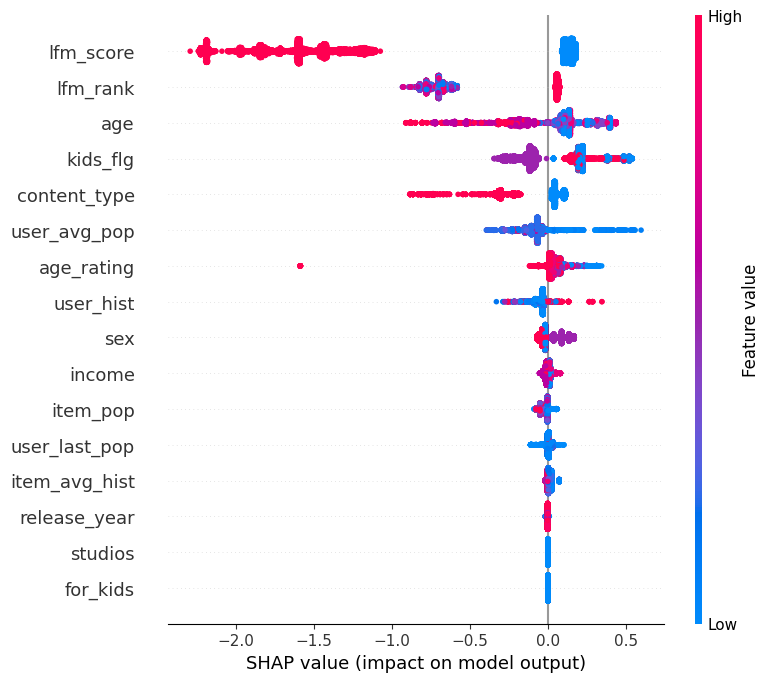

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

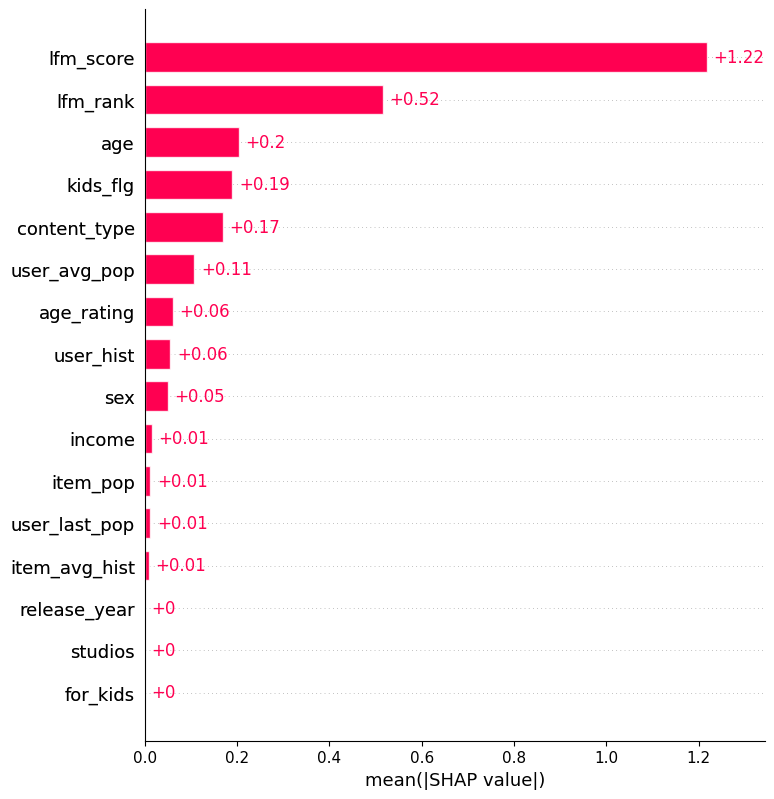

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.02491862, 0.02658528, 0.46738682, ..., 0.0310674 , 0.0310674 ,
       0.03248949])

In [ ]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['lfm_rank'] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
2,1,3669,2021-08-16,1593.0,26.0,-0.010009,11.0,NaN,NaN,1,...,-1,18.0,-1,2846.0,22.675978,0,0.467387,1,0.467387,1
8,1,10440,2021-08-13,19579.0,80.0,-0.010009,11.0,NaN,NaN,1,...,-1,18.0,-1,141889.0,8.068716,1,0.242084,2,0.242084,2
4,1,4151,2021-07-01,0.0,0.0,0.000004,5.0,69641.0,4.0,1,...,-1,18.0,-1,69641.0,10.807886,0,0.033919,3,0.033919,3


In [ ]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)

0.9153137136014569

In [ ]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)

(0.9167469803877124, 0.9167469803877124)

In [ ]:
# Получим значения метрик, а так же
# вспомним, какие метрики были у LightFM и сравним их между собой. Что не так?
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'pointwise', 'pointwise_hybrid']]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.00000,0.322175,0.322175
recall@10,0.00000,0.969868,0.969868
ndcg@10,0.00000,0.444489,0.444489
map@10,0.00000,0.969750,0.969750
novelty@10,3.13255,4.511934,4.511934


In [ ]:
# save model
with open(f'pointwise_model.dill', 'wb') as f:
    dill.dump(pointwise_model, f)

## Pairwise/Listwise

In [ ]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).

# Официальная [дока|https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker]:
# sum(group) = n_samples.
# For example, if you have a 100-document dataset with
# group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups,
# where the first 10 records are in the first group

# Важно! Если вы решите использовать CatBoostRanker или XGBoostRanker - там группы строятся по-другому.

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [ ]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
79137,20179,142,2021-07-01,0.0,0.0,0.000001,10.0,35862.0,8.0,5,...,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,0,0
79138,20179,382,2021-08-12,15.0,0.0,-0.010009,11.0,NaN,NaN,5,...,2858.0,0,1977.0,-1,0.0,-1,116.0,33.922414,0,0
79139,20179,488,2021-08-11,20.0,0.0,-0.010009,11.0,NaN,NaN,5,...,2858.0,0,2020.0,-1,16.0,-1,841.0,28.546968,0,0


In [ ]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.884867
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.415726
[LightGBM] [Debug] init for col-wise cost 0.001025 seconds, init for row-wise cost 0.001795 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 10236, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [ ]:
# save model
with open(f'listwise_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [ ]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.5585273308860997),
             ('ndcg@5', 0.5134761086318487),
             ('ndcg@10', 0.5041897606870871)])

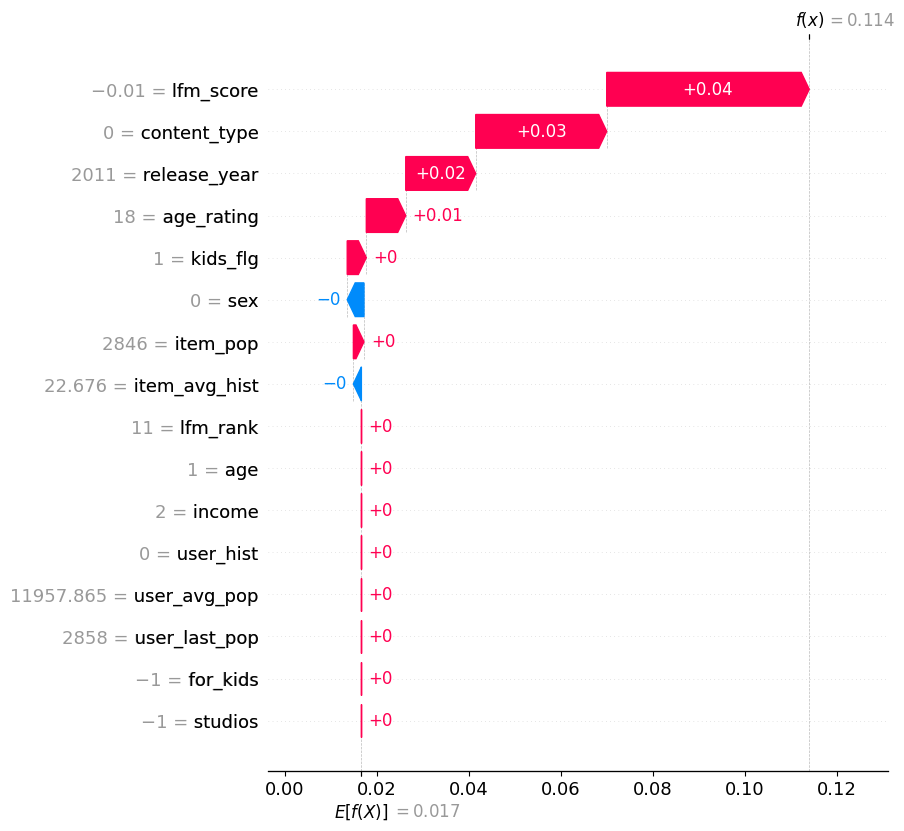

In [ ]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

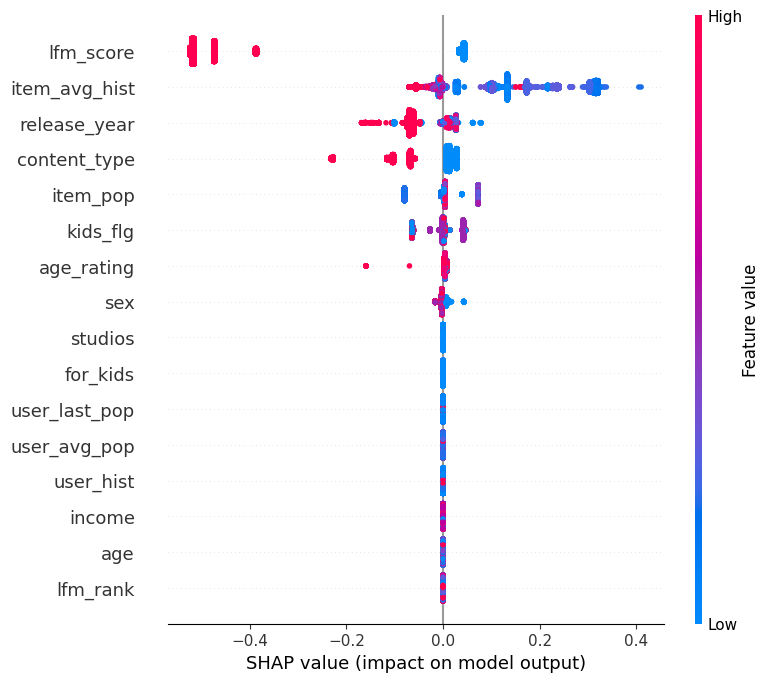

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

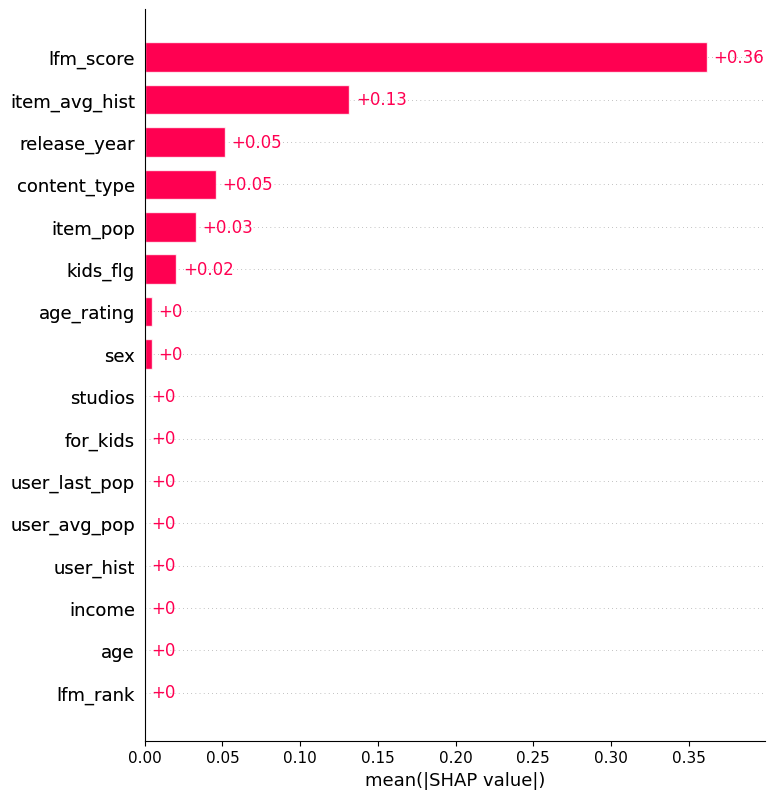

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
2,1,3669,2021-08-16,1593.0,26.0,-0.010009,11.0,NaN,NaN,1,...,0,0.467387,1,0.467387,1,1,0.113927,1,0.113927,1
8,1,10440,2021-08-13,19579.0,80.0,-0.010009,11.0,NaN,NaN,1,...,1,0.242084,2,0.242084,2,2,-0.072693,2,-0.072693,2
5,1,4880,2021-07-01,0.0,0.0,0.000004,6.0,43676.0,7.0,1,...,0,0.033919,4,0.033919,4,0,-0.166489,3,-0.166489,3


In [ ]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.317252,0.317252
recall@10,0.964621,0.964621
ndcg@10,0.429468,0.429468
map@10,0.903727,0.903727
novelty@10,4.474472,4.474472


In [ ]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.9096372221293111, 0.9096372221293111)

In [ ]:
pd.DataFrame(models_metrics)[['lfm', 'pointwise_hybrid', 'listwise_hybrid']]

,lfm,pointwise_hybrid,listwise_hybrid
Precision@10,0.00000,0.322175,0.317252
recall@10,0.00000,0.969868,0.964621
ndcg@10,0.00000,0.444489,0.429468
map@10,0.00000,0.969750,0.903727
novelty@10,3.13255,4.511934,4.474472


## Recos exporting

In [ ]:
# Соединяем все части датасета
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
len(ranker_full)

921781

In [ ]:
# Ранжируем рекомендации
K_RECS = 10
ranker_full = ranker_full[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]
# Выбираем топ-10 рекомендаций
ranker_full = (
    ranker_full.sort_values([Columns.User, "listwise_hybrid_rank"])
    .groupby(Columns.User)
    .head(K_RECS)
)
ranker_full.drop("listwise_hybrid_rank", axis=1, inplace=True)
ranker_full.head()

,user_id,item_id
2,1,3669
8,1,10440
5,1,4880
7,1,9728
0,1,142


In [ ]:
recos_dict = ranker_full.groupby(Columns.User).agg(list).to_dict()[Columns.Item]

In [ ]:
import json

with open('recos.json', "w") as jf:
    json.dump(recos_dict, jf)